In [1]:
import sys
import os
import argparse
import opts

import numpy as np
import cv2
from PIL import Image
import json

from mbench.ytvos_ref import build as build_ytvos_ref

import matplotlib.pyplot as plt
import textwrap

### 1. 데이터 불러오기

In [2]:
if 'ipykernel_launcher' in sys.argv[0]:
    sys.argv = sys.argv[:1]  # Jupyter 추가 인자를 제거

parser = argparse.ArgumentParser('ReferFormer training and evaluation script', parents=[opts.get_args_parser()])
args = parser.parse_args()

#==================데이터 불러오기===================
# 전체 데이터셋
train_dataset = build_ytvos_ref(image_set = 'train', args = args)

# 전체 데이터셋 메타데이터
metas = train_dataset.metas

skipped 57 short videos

 video num:  3471  clip num:  3414




In [6]:
with open('mbench/numbered_captions_gpt-4o_no_mask_color.json', 'r') as file:
    all_captions = json.load(file)

with open('mbench/numbered_valid_obj_ids_gpt-4o_no_mask_color.json', 'r') as file:
    all_valid_obj_ids = json.load(file)

In [7]:
# 색상 후보 8개 (RGB 형식)
colors = [
    (255, 0, 0),    # Red
    (0, 255, 0),    # Green
    (0, 0, 255),    # Blue
    (255, 255, 0),  # Yellow
    (255, 0, 255),  # Magenta
    (0, 255, 255),  # Cyan
    (128, 0, 128),  # Purple
    (255, 165, 0)   # Orange
]

### 2. 시각화

In [8]:
def checkCaption(idx, all_captions, all_valid_obj_ids, color_mask = False):
    vid_meta = metas[idx]
    vid_id = vid_meta['video']
    frames = vid_meta['frames']
    print(vid_id)

    first_cat = list(all_captions[vid_id].keys())[0]
    sampled_frames = list(all_captions[vid_id][first_cat].keys())
    imgs = []
    masks = []
    for frame_indx in sampled_frames:
        frame_name = frames[int(frame_indx)]
        img_path = os.path.join(str(train_dataset.img_folder), 'JPEGImages', vid_id, frame_name + '.jpg')
        mask_path = os.path.join(str(train_dataset.img_folder), 'Annotations', vid_id, frame_name + '.png')
        img = Image.open(img_path).convert('RGB')
        imgs.append(img)
        mask = Image.open(mask_path).convert('P')
        mask = np.array(mask)
        masks.append(mask)

    vid_captions = all_captions[vid_id]
    cat_names = set(list(vid_captions.keys()))

    for cat in cat_names:
        
        cat_captions = vid_captions[cat]

        for i in range(len(imgs)):
            frame_name = sampled_frames[i]
            frame = np.copy(np.array(imgs[i]))
            frame_for_contour = np.copy(np.array(imgs[i]))

            mask = masks[i] 

            all_obj_ids = np.unique(mask).astype(int)
            all_obj_ids = [str(obj_id) for obj_id in all_obj_ids if obj_id != 0]
            
            if cat in all_valid_obj_ids[vid_id]:
                valid_obj_ids = all_valid_obj_ids[vid_id][cat]
            else:
                valid_obj_ids = []

            for j in range(len(all_obj_ids)):
                obj_id = all_obj_ids[j]
                obj_mask = (mask == int(obj_id)).astype(np.uint8)
            
                if obj_id in valid_obj_ids:
                    if color_mask == False:
                        contours, _ = cv2.findContours(obj_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                        cv2.drawContours(frame, contours, -1, colors[j], 3)
                        for i, contour in enumerate(contours):
                            # 윤곽선 중심 계산
                            moments = cv2.moments(contour)
                            if moments["m00"] != 0:  # 중심 계산 가능 여부 확인
                                cx = int(moments["m10"] / moments["m00"])
                                cy = int(moments["m01"] / moments["m00"])
                            else:
                                cx, cy = contour[0][0]  # 중심 계산 불가시 대체 좌표 사용
                            
                            # 텍스트 배경 (검은색 배경 만들기)
                            font = cv2.FONT_HERSHEY_SIMPLEX
                            text = obj_id
                            text_size = cv2.getTextSize(text, font, 1, 2)[0]
                            text_w, text_h = text_size
                            
                            # 텍스트 배경 그리기 (검은색 배경)
                            cv2.rectangle(frame, (cx - text_w // 2 - 5, cy - text_h // 2 - 5),
                                        (cx + text_w // 2 + 5, cy + text_h // 2 + 5), (0, 0, 0), -1)
                            
                            # 텍스트 그리기 (흰색 텍스트)
                            cv2.putText(frame, text, (cx - text_w // 2, cy + text_h // 2),
                                        font, 1, (255, 255, 255), 2)
                    else:
                        alpha = 0.08
                        colored_obj_mask = np.zeros_like(frame)
                        colored_obj_mask[obj_mask == 1] = colors[j]
                        frame[obj_mask == 1] = (
                            (1 - alpha) * frame[obj_mask == 1]
                            + alpha * colored_obj_mask[obj_mask == 1]
                        )


                        contours, _ = cv2.findContours(obj_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                        cv2.drawContours(frame, contours, -1, colors[j], 2)
                        cv2.drawContours(frame_for_contour, contours, -1, colors[j], 2)
                        
                        
                        
                        if len(contours) > 0:
                            largest_contour = max(contours, key=cv2.contourArea)
                            M = cv2.moments(largest_contour)
                            if M["m00"] != 0:  
                                center_x = int(M["m10"] / M["m00"])
                                center_y = int(M["m01"] / M["m00"])
                            else:
                                center_x, center_y = 0, 0

                        font = cv2.FONT_HERSHEY_SIMPLEX
                        text = obj_id

                        font_scale = 0.9  
                        text_size = cv2.getTextSize(text, font, font_scale, 2)[0]                        
                        text_x = center_x - text_size[0] // 1  # 텍스트의 가로 중심
                        text_y = center_y
                        # text_y = center_y + text_size[1] // 2 # 텍스트의 세로 중심

                        # 텍스트 배경 사각형 좌표 계산
                        rect_start = (text_x - 5, text_y - text_size[1] - 5)  # 배경 사각형 좌상단
                        # rect_end = (text_x + text_size[0] + 5, text_y + 5) 
                        rect_end = (text_x + text_size[0] + 5, text_y)

                        cv2.rectangle(frame, rect_start, rect_end, (0, 0, 0), -1)
                        cv2.putText(frame, text, (text_x, text_y), font, 1, (255, 255, 255), 2)
                        
            fig, ax = plt.subplots()
            ax.imshow(frame)
            ax.axis('off')

            frame_caption = cat_captions[frame_name]
            if frame_caption:
                wrapped_text = "\n".join(textwrap.wrap(frame_caption, width=60))
                ax.text(0.5, -0.3, wrapped_text, ha='center', va='center', fontsize=12, transform=ax.transAxes)
            
            plt.title(f"vid_id: {vid_id}, cat: {cat}, frame: {frame_name}")
            plt.tight_layout()
            plt.show()


03c95b4dae


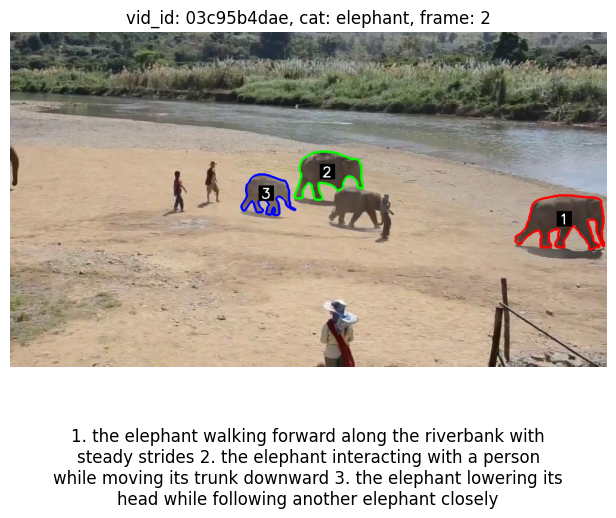

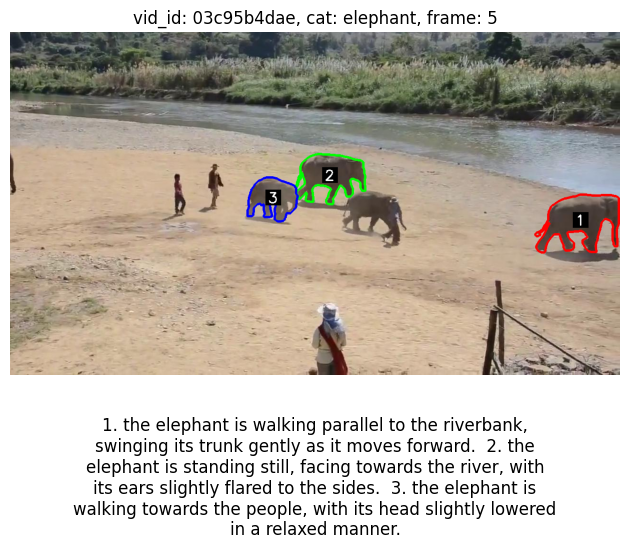

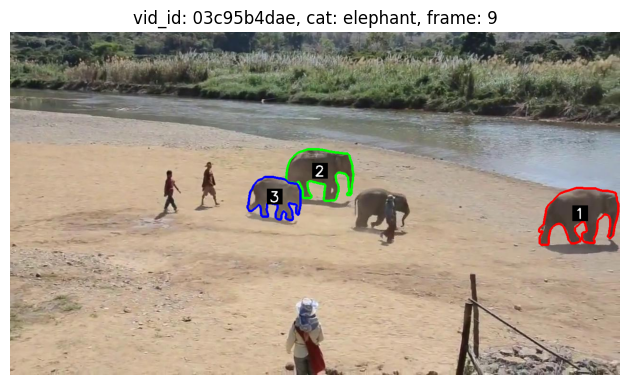

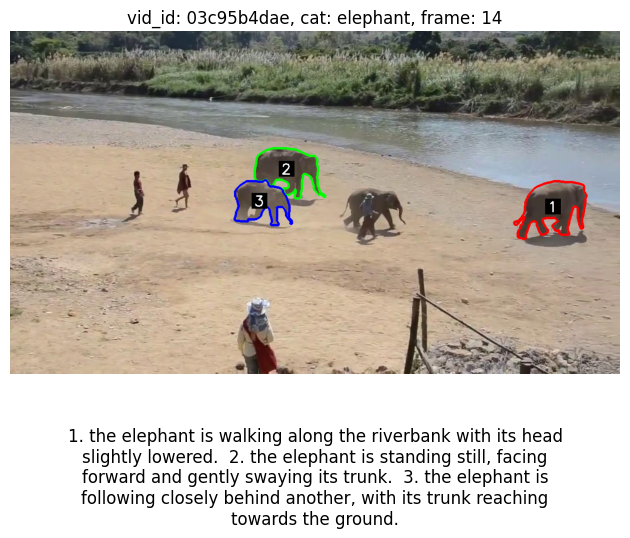

In [50]:
checkCaption(40, all_captions, all_valid_obj_ids, False)